# Apresentação:

Tudo no computador são processos matemáticos e **Redes Neurais** não são diferentes. Apesar de dizermos que **LLMs (_Large Language Models_)** trabalharem com texto, o computador não lê nada, no realidade o modelo está realizando um monte de contas. 

A solução encontrada para fazer o contas com texto foram os **embeddings**: conversões de palavras em vetores numéricos.

Embora existam técnicas como **_Word2Vec_** para criar esses **_embeddings_**, os **LLMs** modernos (GPT-2, GPT-3) geram seus próprios _embeddings_ durante o treinamento, otimizando-os especificamente para suas tarefas. Esses _embeddings_ têm centenas ou milhares de dimensões (GPT-2 usa 768, GPT-3 usa 12.288).

O capítulo prepara o leitor para aprender três etapas práticas: dividir texto em palavras/subpalavras (**tokenização**), codificar esses tokens e convertê-los em vetores que alimentam o modelo.


**Este capítulo abrange:**

- Preparação de texto para o treinamento de modelos de linguagem de grande escala (LLMs).
- Divisão de texto em tokens de palavras e subpalavras.
- Byte pair encoding (BPE) como um método mais avançado de tokenização de texto.
- Amostragem de exemplos de treinamento utilizando a abordagem de janela deslizante (sliding window).
- Conversão de tokens em vetores que alimentam um modelo de linguagem de grande escala.


## Material de Apoio:

- [Documentação PyTorch](https://docs.pytorch.org/docs/stable/index.html)


In [2]:
import sys
import os
from pathlib import Path

# Encontra o diretório raiz do projeto (onde está a pasta 'utils')
notebook_dir = Path.cwd()
root_dir = notebook_dir.parent.parent  # Sobe dois níveis

# Adiciona ao sys.path
if str(root_dir) not in sys.path:
    sys.path.insert(0, str(root_dir))

In [2]:
from utils.utilities import get_image

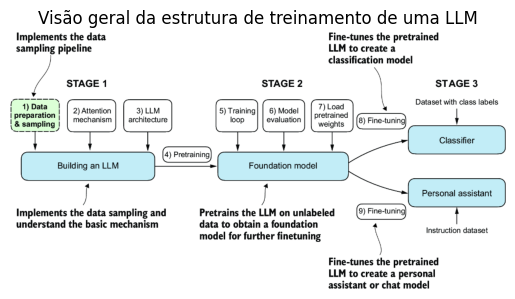

In [4]:
# Visão geral da estrutura de treinamento de uma LLM
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-1.png",
    title="Visão geral da estrutura de treinamento de uma LLM"
    )

# Tokenização de Texto:

Vamos discutir como dividimos o texto de entrada em tokens individuais, uma etapa de pré-processamento necessária para criar embeddings para um LLM. Esses tokens são palavras individuais ou caracteres especiais, incluindo caracteres de pontuação.

In [ ]:
# Dependências utilizadas:
import os
import requests

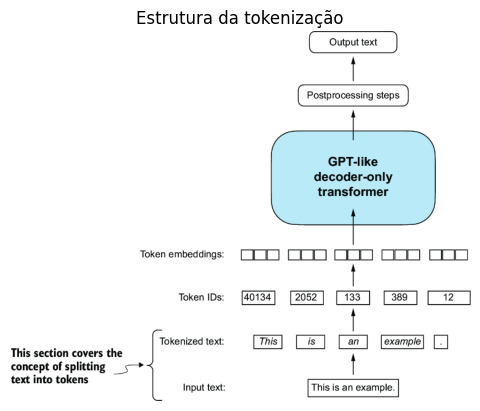

In [ ]:
# Imagem da estruturação da tokenização:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-4.png",
    title = "Estrutura da tokenização"
    )

        Uma visão das etapas de processamento de texto no contexto de um LLM. Aqui, dividimos um texto de entrada em tokens individuais, que são palavras ou caracteres especiais, como caracteres de pontuação.

## Aquisitando dados:

O texto que vamos tokenizar para o treinamento do LLM é ["O Veredito"](https://en.wikisource.org/wiki/The_Verdict), um conto de Edith Wharton, que foi liberado para domínio público e, portanto, pode ser usado para tarefas de treinamento do LLM.


OBS:

    O livro apresenta outro código que usa o urllib. Contudo, o urllib antigos em suas configurações, que podem dar problemas com usuários que usam VPN, cuja é meu caso.

In [ ]:
# Diretório armazeandor dos dados
file_path = "data/the-verdict.txt" 

if not os.path.exists(file_path):
    url = (
        "https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
        "the-verdict.txt"
    )
    
    # Baixa o arquivo se ele não existir
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    with open(file_path, "wb") as f:
        f.write(response.content)

In [ ]:
# Instanciando o texto bruto:
with open(file_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

In [ ]:
# verificando texto:
print("#" * 20+" Quantidades " + "#"*20)
print(f"Quantidade de caracteres: {len(raw_text)}")
print(f"Quantidade de palavras: {len(raw_text.split())}")
print()
print("#" * 20+" Primeiras 500 caracteres " + "#"*20)
print(raw_text[:500])  # Mostra os primeiros 500 caracteres do texto

#################### Quantidades ####################
Quantidade de caracteres: 20479
Quantidade de palavras: 3634

#################### Primeiras 500 caracteres ####################
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


## Tokenização:

Com o texto em mãos, iniciaremos o processamento dos dados. Existem inúmeras ferramentas para isso como o `NLTK`, `spaCy`, entre outras. Aqui, o livro faz isso via `re`, biblioteca **Python** para utilização de Expressões Regulares (_regex_).

**Nota:** Por vezes as pessoas consideram Tokenização == _embeddings_ só que esses termos **não** são equivalentes! Tokenização é o começo do processo de processamento do texto, é a forma que vamos serar o texto, é puro tratamento de string, não tem nada de codificação ainda.

In [ ]:
import re

In [ ]:
# Exemplo de implementação:
text = "Hello, world. This, is a test." # Testo de exemplo:
result = re.split(r'(\s)', text) # Split por espaços em brancos
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


Porém, queremos também individualizar a pontuação.

In [ ]:
result = re.split(r'([,.]|\s)', text)  # Split por vírgulas, pontos e espaços em brancos
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


Esse processo cria strings vazias, o que não é relevante nesse contexto, então podemos remove-las.

In [ ]:
# Removendo tokens vazios:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [ ]:
# Exemplo mais completo:
text = "Hello, world. Is this-- a test?"

# Generalizando solução para múltiplas pontuações:
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [ ]:
# Tokenizando o texto:
tokens = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
tokens = [item.strip() for item in tokens if item.strip()]
print(tokens[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [ ]:
# Quantidade de tokens:
print(len(tokens))

4690


## Convertendo Tokens em IDs de Tokens:

Aqui vamos começar a transformar essa massa de _strings_ em número, começando a convertendo as strings em representações inteiras. Essa conversão é uma etapa intermediária antes de converter os IDs dos tokens em **vetores semânticos** (_embeddings_).

    O livro não comenta, mas isso vem lá do Bag-of-Words. Essa era a forma que os textos eram "matematizados", digamos assim. Só que essa forma de representar não é boa, porque gera matrizes esparças, entre outros fatores mais técnicos. Os vetores semanticos, objetos matemáticos no domínio dos reais, se mostram mais competêntes em gerar representações mais eficientes do que codificações limitadas ao domínio dos naturais. Além de possibilitarem a matemática vetorial utilizada na construção dos espaços vetoriais, objeto matemático fundamental na construção dos modelos de linguagem. Historicamente falando, os vetores semanticos (vetores reais ao invés de matrizes esparças de numeros inteiros) foram uma das mudança de chave pra construção das LLMs.


Para mapear os **tokens** gerados anteriormente em **IDs de token**, primeiro precisamos construir um **vocabulário**. Esse **vocabulário** define como mapeamos cada palavra única e caractere especial para um número inteiro único.

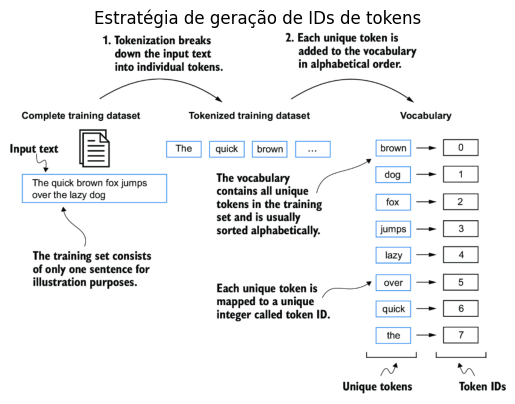

In [ ]:
# Estratégia de geração de IDs de tokens    
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-6.png",
    title="Estratégia de geração de IDs de tokens"
)

Construímos um vocabulário tokenizando todo o texto de um conjunto de dados de treinamento em tokens individuais. Esses tokens individuais são então classificados alfabeticamente e os tokens duplicados são removidos.

Os tokens únicos são então agregados em um vocabulário que define um mapeamento de cada token único para um valor inteiro único. O vocabulário apresentado é propositalmente pequeno e não contém pontuação ou caracteres especiais para simplificar.

In [ ]:
# Quantidade de tokens únicos (tamanho do vocabulário):
all_words = sorted(set(tokens)) # Conjunto de tokens únicos
vocab_size = len(all_words)
print(vocab_size)

1130


In [ ]:
# Gerando o vocabulário (mapeamento token -> ID):
vocab = {token:integer for integer, token in enumerate(all_words)}

In [ ]:
# Visualizando os 20 primeiros itens do vocabulário:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 20:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


O dicionário contém tokens individuais associados a rótulos inteiros únicos. Nosso próximo objetivo é aplicar esse vocabulário para converter novos textos em IDs de tokens

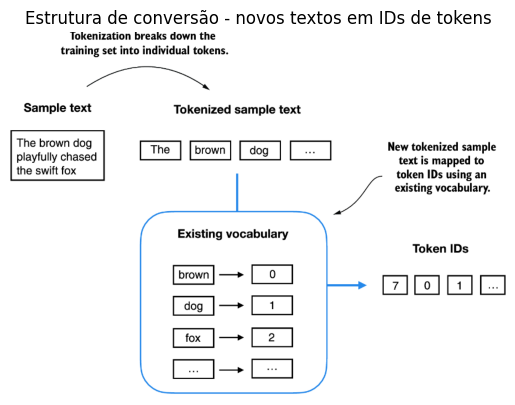

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-7.png",
    title="Estrutura de conversão - novos textos em IDs de tokens"
)

Partindo de uma nova amostra de texto, tokenizamos o texto e usamos o vocabulário para converter os tokens de texto em IDs de token.

O vocabulário é construído a partir de todo o conjunto de treinamento e pode ser aplicado ao próprio conjunto de treinamento e a quaisquer novas amostras de texto. O vocabulário apresentado não contém pontuação nem caracteres especiais para simplificar.

### Tokenizer

Quando queremos converter as saídas de um LLM de números de volta para texto, precisamos de uma maneira de transformar os IDs dos tokens em texto. Para isso, podemos criar uma versão inversa do vocabulário que mapeia os IDs dos tokens de volta para os tokens de texto correspondentes. Isso tudo será unificado na classe `SimpleTokenizerV1`.

In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_id = vocab 
        self.id_to_str = {id_: str_ for str_, id_ in vocab.items()}


    def encode(self, text):
        """
        Converte o texto em uma lista de IDs de tokens.

        Args:
            text (str): O texto a ser convertido.
        Returns:
            List[int]: A lista de IDs de tokens.
        """
        tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        tokens = [item.strip() for item in tokens if item.strip()]
        token_ids = [self.str_to_id[token] for token in tokens]
        return token_ids
    
    def decode(self, token_ids):
        """
        Converte uma lista de IDs de tokens de volta para texto.
        Args:
            token_ids (List[int]): A lista de IDs de tokens.
        Returns:
            str: O texto reconstruído.
        """
        tokens =  " ".join([self.id_to_str[i] for i in token_ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', tokens)
        return text

Nota:

    Apesar do nome, esse encode e decode não tem nada a ver com o encoder e decoder da arquitetura Transformers que veremos mais na frente.

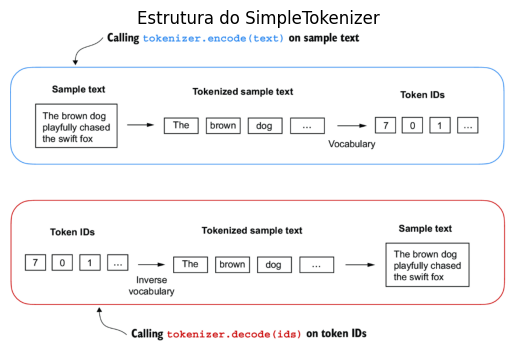

In [ ]:
# Estrutura do SimpleTokenizer
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-8.png",
    title="Estrutura do SimpleTokenizer"
)

In [ ]:
# Instanciando tokenizer
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [ ]:
# Transformando IDs em texto novamente
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


Talvez a ideia de "vocabulário" possa ficar um pouco abstrata de se entender, mas é um tanto simples. O vocabulário nada mais é do que a capacidade do sistema de mapear texto em IDs numéricos.

Ou seja, ele é um uma quantidade grande de palavras que gere a maior quantidade de tokens possíveis. Dai, o tokenizador só vai conseguir mapear texto em IDs, de textos que estiverem dentro do vocabulário.

In [ ]:
# Um teste errado para exemplificar
ids = tokenizer.encode("Olá, mundo!")
print(ids)

KeyError: 'Olá'

"Olá" não faz parte do vocabulário, ou seja, o sistema não sabe mapear ele em IDs.

# Adicionando tokens de contexto especiais

Precisamos modificar o tokenizador para lidar com palavras desconhecidas. Também precisamos abordar o uso e a adição de **tokens de contexto** especiais que podem aprimorar a compreensão do contexto ou de outras informações relevantes no texto por parte do modelo. Esses **tokens especiais** podem incluir marcadores para palavras desconhecidas e limites de documentos, por exemplo. Em particular, modificaremos o vocabulário e o tokenizador `SimpleTokenizerV2` para suportar dois novos tokens, `<|unk|>`e `<|endoftext|>`.

- `<|unk|>`: Token especial para lidar com palavra desconhecida, ou seja, palavra que não faz parte do vocabulário.
- `<|endoftext|>`: Token especial que podemos usar para separar duas fontes de texto não relacionadas. (Isso ajuda o **LLM** a entender que, embora essas fontes de texto sejam concatenadas para treinamento, elas são, na verdade, independentes.)

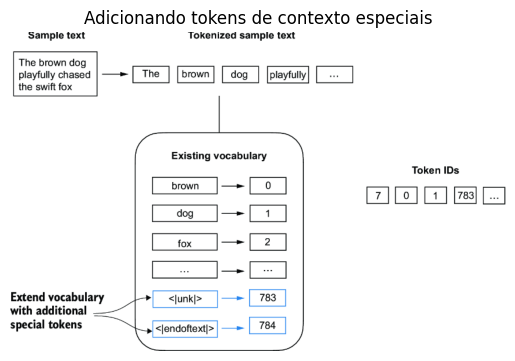

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-9.png",
    title="Adicionando tokens de contexto especiais"
)

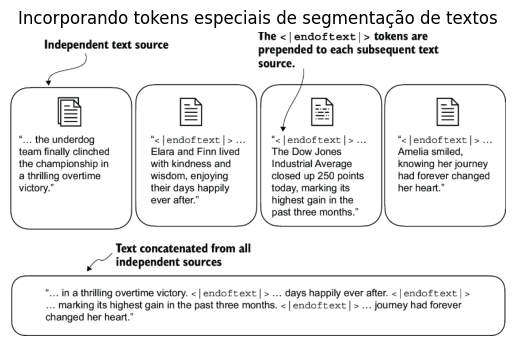

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-10.png",
    title = "Incorporando tokens especiais de segmentação de textos"
)

Alguns desses tokens especiais são:

- **[BOS]** (_beginning of sequence_): marca o início do texto.

- **[EOS]** (_end of sequence_): marca onde o texto termina (isso é geralmente usado para concatenar múltiplos textos não relacionados, como dois artigos diferentes da Wikipédia, dois livros distintos, etc.).

- **[PAD]** (_padding_): se treinarmos **LLMs** com um **tamanho de lote (_batch size_)** maior que 1, podemos incluir vários textos com comprimentos diferentes; com o **token de preenchimento (_padding_)**, preenchemos os textos mais curtos até que alcancem o comprimento do mais longo, para que todos os textos tenham o mesmo tamanho.

- **[UNK]** (_unknown_): usado para representar palavras que não estão incluídas no vocabulário.

Observações sobre o GPT-2:
- **Simplicidade:** Note que o GPT-2 não precisa de nenhum dos tokens mencionados acima; ele utiliza apenas um token `<|endoftext|>` para reduzir a complexidade.

- Analogia: O `<|endoftext|>` é análogo ao token **[EOS]** mencionado anteriormente.

Preenchimento: O GPT também usa o `<|endoftext|>` para o preenchimento (já que normalmente usamos uma máscara ao treinar com entradas em lote, não daríamos atenção aos tokens de preenchimento de qualquer forma, então não importa quais sejam esses tokens).

Vocabulário: O GPT-2 não usa um token `<|UNK|>` para palavras fora do vocabulário. Em vez disso, ele utiliza um tokenizador **BPE (_byte-pair encoding_)**, que divide as palavras em unidades de subpalavras (que serão discutidas em uma seção posterior).

In [ ]:
# Adicionando os tokens especiais ao vocabulário
all_tokens = sorted(list(set(tokens)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [ ]:
# Tamanho do vocabulário atual
len(vocab.items())

1132

In [ ]:
# Visualizando os novos itens do vocabulário:
for i, item in enumerate(list(vocab.items())[-2:]):
    print(item)

('<|endoftext|>', 1130)
('<|unk|>', 1131)


Agora precisamos ajustar o tokenizer para lidar com o novo token `<|unk|>`

In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_id = vocab
        self.id_to_str = {id_: str_ for str_, id_ in vocab.items()}

    def encode(self, text):
        tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        tokens = [item.strip() for item in tokens if item.strip()]
        
        # Etapa de substituição de tokens desconhecidos
        tokens = [token if token in self.str_to_id else "<|unk|>" for token in tokens]

        # Gerando IDs:
        ids = [self.str_to_id[token] for token in tokens]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.id_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [ ]:
# Instanciando o novo tokenizer
tokenizer = SimpleTokenizerV2(vocab)

In [ ]:
# Textos:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

# Texto unificado:
text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [ ]:
ids = tokenizer.encode(text);ids

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [ ]:
for i in ids:
    if i == 1131 or i == 1130:
        print(f" {i} -> {tokenizer.id_to_str[i]}")    

 1131 -> <|unk|>
 1130 -> <|endoftext|>
 1131 -> <|unk|>


Note que assim podemos até contar quantas palavras fora do vocabulário temos. Isso é útil para gerar estatísticas sobre o treinamento, avaliação da qualidade dos dados, etc.

In [ ]:
# Convertendo de volta para texto
tokenizer.decode(ids)

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

Se repetirmos noss teste anterior.

In [ ]:
# Um teste errado para exemplificar
ids = tokenizer.encode("Olá, mundo!")
print(ids, tokenizer.decode(ids))

[1131, 5, 1131, 0] <|unk|>, <|unk|>!


# 2.5 BytePair encoding

Vamos analisar  baseado em um conceito chamado codificação de **pares de bytes (BPE)**. O **tokenizador BPE** é um esquema de tokenização mais sofisticado que foi usado para treinar LLMs como o **GPT-2**, o **GPT-3** e o modelo original usado no ChatGPT (Periodo do Livro - 2024).


Como a implementação do **BPE** pode ser relativamente complexa, utilizaremos uma biblioteca Python de código aberto chamada [`tiktoken`](https://github.com/openai/tiktoken),  que implementa o algoritmo BPE de forma muito eficiente com base em código-fonte em Rust.

**Benefício dessa Tokenização:**

Essa técnica permite que o modelo decomponha palavras que não estão em seu vocabulário predefinido em unidades menores (subpalavras) ou até mesmo em caracteres individuais. Isso possibilita que o modelo lide com palavras fora do vocabulário (_out-of-vocabulary_).

Por exemplo, se o vocabulário do GPT-2 não contiver a palavra "unfamiliarword", ele poderá tokenizá-la como ["unfam", "iliar", "word"] ou outra divisão em subpalavras, dependendo das junções (_merges_) aprendidas durante o treinamento do _BPE_. Dessa forma, um tokenizador BPE pode analisar qualquer palavra e não precisa substituir palavras desconhecidas por tokens especiais, como `<|unk|>`.

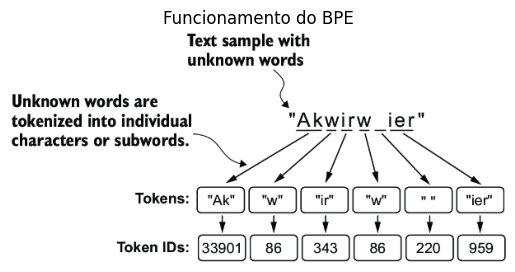

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-11.png",
    title="Funcionamento do BPE"
)

**Nota:**

O um **método heurístico de segmentação de texto** que aprende subunidades (“subword u´its”) com base em frequências de pares de bytes ou caracteres. É um método e NLP de geração de vocabulário por meio de subpalavras. Ao que me parece, a OpenAI criou a sua própria implementação da estratégia e usou-a para expandir a capacidade da sua tokenização. Foi a solução que encontraram para lidar com um vocabulário fixo. Alguns artigos que ajudam a entender a técnica.

- [A New Algorithm for Data Compression Optimization](https://arxiv.org/pdf/1209.1045)
- [A Formal Perspective on Byte-Pair Encoding](https://arxiv.org/abs/2306.16837)
- [Theoretical Analysis of Byte-Pair Encoding](https://arxiv.org/pdf/2411.08671)

In [ ]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.12.0


In [ ]:
# Instanciando tokenizador
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
# Texto:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

In [ ]:
# Codificando texto para ids:
ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"});print(ids)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [ ]:
# Decodificando ids para texto:
strings = tokenizer.decode(ids)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


# Amostragem de dados com janela deslizante

A tarefa de predição do **LLM** durante o treinamento é prever a próxima palavra que segue o bloco de entrada. E o que faz uma LLM funcionar assim é justamente a estratégia de pares de **entrada-alvo (_input-target_)**.

Durante o treinamento, mascaramos todas as palavras que estão além do alvo. Observe que o texto mostrado nesta figura precisa passar por tokenização antes que o LLM possa processá-lo; no entanto, esta figura omite a etapa de tokenização para maior clareza. 

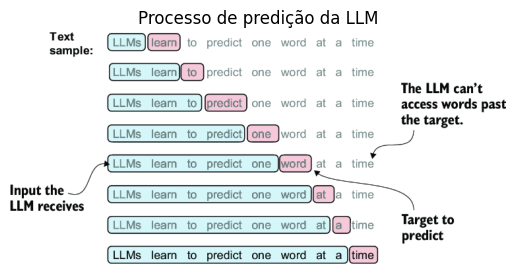

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-12.png",
    title="Processo de predição da LLM"
    )

É daqui que surge a ideia da **LLM** como um modelo **regressivo**, porque ela usa os tokens preditos para prever os próximo, tudo num protesso auto-regressivo.

**Nota:**

    O livro não menciona, mas historicamente muitos sistemas usavam modelos por n-gramas — sequências fixas de n palavras consecutivas — e inferiam a próxima palavra por meio de contagens e probabilidades condicionais estimadas no corpus (com técnicas de smoothing para contornar a escassez de dados). Assim como o Bag-of-Words, os modelos de n-grama são métodos clássicos que funcionam bem em cenários limitados, mas têm limitações fundamentais (alta dimensionalidade, esparsidade, e incapacidade de capturar dependências de longo alcance). Com a chegada de representações distribuídas (embeddings) e modelos neurais (RNNs, Transformers), passou-se a usar representações contínuas e modelos que generalizam muito além das sequências vistas — por isso hoje n-gramas e BoW são tratados como técnicas históricas/clássicas, úteis para entender a evolução da área, mas raramente usados em LLMs modernos.

In [ ]:
with open("data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


- Para cada trecho de texto (_chunk_), queremos as entradas (_inputs_) e os alvos (_targets_).

- Como queremos que o modelo preveja a próxima palavra, os alvos são as entradas deslocadas em uma posição para a direita. (Que é direção da leitura de linguas ocidentais).

In [ ]:
# Amostra
enc_sample = enc_text[50:]

In [ ]:
# Exemplo de predição
context_size = 4 # Tamanho do contexto
 
x = enc_sample[:context_size] # input
y = enc_sample[1:context_size+1] # target

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


Uma a uma, a previsão seria mais ou menos assim.

In [ ]:
# Exemplo de Predição
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


Daqui que nasce a ideia de que uma LLM é, em resumo, um preditor de texto _gourmet_ de celular. Vemos que não é uma afirmação completamente mentirosa, mas também não é completamente verdadeira, dado que isso aqui não é nem a metade do entendimento do assunto, toda a complexidade matemática está sendo jogada pra debaixo do tapete e para além disso... Em verdade, nem entramos no estudo das LLMs de fato, esse ainda é o capítulo de processamento de texto.

In [ ]:
# Avaliando o texto
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


Só falta mais uma tarefa antes de podermos transformar os tokens em _embeddings_: implementar um carregador de dados eficiente que itere sobre o conjunto de dados de entrada e retorne as entradas e os alvos como tensores **PyTorch**, que podem ser vistos como **arrays multidimensionais**. Em particular, estamos interessados ​​em retornar dois **tensores**: um **tensor de entrada contendo o texto que o LLM vê** e **um tensor de alvo que inclui os alvos que o LLM deve prever**.

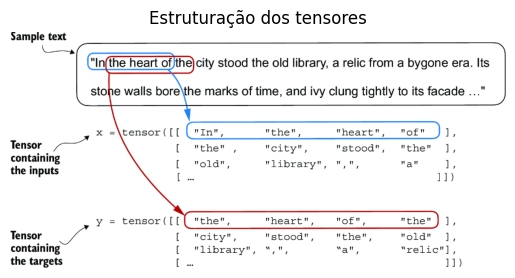

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-13.png",
    title = "Estruturação dos tensores"
)

Coletamos as entradas em um tensor, $x$, onde cada linha representa um contexto de entrada. Um segundo tensor, $y$, contém os alvos de previsão correspondentes (próximas palavras), que são criados deslocando a entrada em uma posição. Para uma implementação eficiente, utilizaremos aqui a classes nativas do **PyTorch**, `Dataset` e `DataLoader`.

**Nota:**
Embora a figura mostre os tokens em formato de string para fins de ilustração, a implementação do código operará diretamente nos IDs dos tokens, visto que o encodemétodo do tokenizador BPE realiza tanto a tokenização quanto a conversão em IDs de tokens em uma única etapa.

In [ ]:
# Importando dependências
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
class GPTDatasetV1(Dataset):
    def __init__(
            self,
            txt,         # Texto bruto de treinamento (ex: um livro inteiro)
            tokenizer,   # Tokenizer responsável por converter texto em IDs de tokens
            max_length,  # Tamanho máximo da sequência de entrada (janela de contexto)
            stride       # Passo da janela deslizante ao percorrer os tokens
            ):
        
        self.input_ids = []
        self.target_ids = []

        # Tokeniza o texto inteiro
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Número de entradas tokenizadas deve ser pelo menos igual a max_length+1."

        # Usa uma janela deslizante para dividir o livro em sequências sobrepostas de comprimento máximo (max_length).
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i +1: i + max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(
        txt,                # Texto bruto de treinamento (corpus ou documento concatenado)
        batch_size = 4,     # Número de amostras (janelas) por batch de treino
        max_length = 256,   # Tamanho da janela de contexto (número de tokens por amostra)
        stride = 128,       # Passo da janela deslizante ao percorrer o texto tokenizado
        shuffle = True,    # Se True, embaralha as amostras a cada época de treino
        drop_last = True,  # Se True, descarta o último batch caso ele seja menor que batch_size
        num_workers = 0,   # Número de processos paralelos para carregar os dados
        toke_encoding = "gpt2"  # Esquema de tokenização usado pelo tiktoken (ex: "gpt2", "cl100k_base")
        ):
    
    # Inicializa o tokenizer
    tokenizer = tiktoken.get_encoding(toke_encoding)

    # Cria o dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Cria o dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last, # drop_last=True descarta o último lote se ele for menor que o tamanho de lote especificado para evitar picos de perda durante o treinamento.
        num_workers=num_workers # O número de processos de CPU a serem usados ​​para o pré-processamento.
    )

    return dataloader

In [ ]:
# Criando dataloader
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464]])]


In [ ]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807]])]


Se compararmos o primeiro e o segundo lotes, podemos ver que os IDs dos tokens do segundo lote são deslocados em uma posição (por exemplo, o segundo ID na entrada do primeiro lote é 367, que é o primeiro ID da entrada do segundo lote). 

A _stride_ configuração determina o número de posições que as entradas deslocam entre os lotes, emulando uma abordagem de janela deslizante

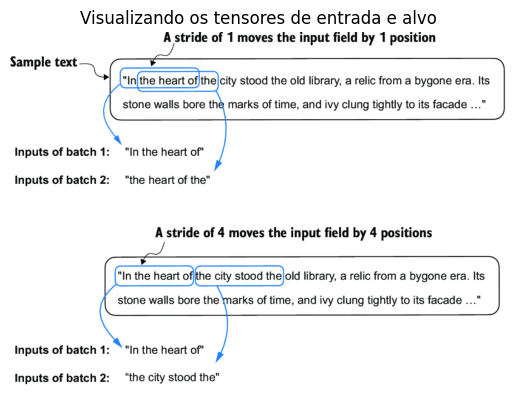

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-14.png",
    title="Visualizando os tensores de entrada e alvo"
)

Ao criar vários lotes a partir do conjunto de dados de entrada, deslizamos uma janela de entrada ao longo do texto. Se o espaçamento (_stride_) for definido como 1, deslocamos a janela de entrada uma posição ao criar o próximo lote. Se definirmos o espaçamento (_stride_) igual ao tamanho da janela de entrada, podemos evitar sobreposições entre os lotes.

# Criação de _embeddings_

A última etapa na preparação do texto de entrada para o treinamento do LLM é converter os IDs dos tokens em vetores de semanticos (_embeddings_).

Como etapa preliminar, devemos inicializar esses pesos de incorporação com valores aleatórios. Essa inicialização serve como ponto de partida para o processo de aprendizado do LLM. No [capítulo 5](), otimizaremos os pesos de incorporação como parte do treinamento do LLM.

        A partir daqui o livro adota valores fictícios para pras dimensões/tamanho dos vetores a fim de buscar valores mais próximos de um contexto real.
    

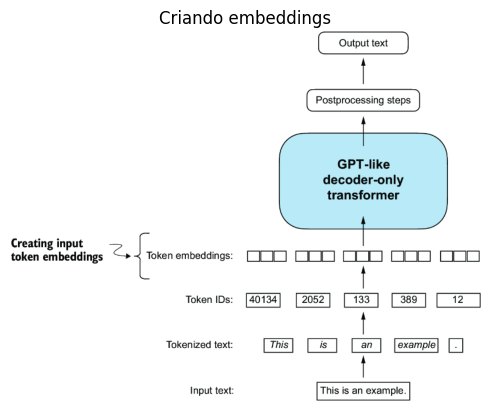

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-15.png",
    title="Criando embeddings"
)

Uma representação vetorial contínua, ou _embedding_, é necessária, uma vez que os modelos de linguagem (LLMs) semelhantes ao GPT são **redes neurais profundas** treinadas com o algoritmo de _backpropagation_.

In [ ]:
# Exemplo:
input_ids = torch.tensor([2, 3, 5, 1]) # Suponha os seguintes ids (pos tokenização)

Para simplificar, suponha que temos um pequeno vocabulário de apenas 6 palavras e queremos criar representações vetoriais de tamanho 3:

In [ ]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

**`vocab_size`:** O parâmetro `vocab_size` define o tamanho do vocabulário, ou seja, o número total de tokens distintos que podem ser representados. Cada token é identificado por um inteiro no intervalo `[0, vocab_size - 1]`.

**`output_dim`:** O parâmetro `output_dim` define a dimensionalidade do espaço vetorial onde os tokens serão projetados. Cada token será representado por um vetor denso de números reais com output_dim componentes.

**`torch.nn.Embedding`:**

A camada `torch.nn.Embedding` cria internamente uma matriz de pesos de dimensão (`vocab_size` × `output_dim`). 

$$W_E ∈ \mathbb{R}^{(vocab\ size × output\ dim)}$$
Cada linha dessa matriz corresponde ao `embedding` de um token. Durante o treinamento, esses vetores são ajustados via _backpropagation_ para capturar relações semânticas entre os tokens. Este módulo é frequentemente usado para armazenar representações vetoriais de palavras (_word embeddings_) e recuperá-las usando índices. Basicamente é uma matriz de dimensões (`vocab_size` × `output_dim`) que funciona como uma tabela de consulta.


In [ ]:
# Obtendo os embeddings
print(embedding_layer.weight)


Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


Para aqueles que estão familiarizados com o **_one-hot encoding_**, a abordagem de camada de _embeddings_ (_embedding layer_) mencionada acima é, essencialmente, apenas uma forma mais eficiente de implementar o _one-hot encoding_ seguido por uma multiplicação de matrizes em uma camada totalmente conectada (_fully-connected layer_). Isso está descrito no código suplementar em [./embedding_vs_matmul](https://github.com/rasbt/LLMs-from-scratch/tree/47cfc61800b4441a4bb15fed980b71ccd1a7d6de/ch02/03_bonus_embedding-vs-matmul).

Como a camada de _embedding_ é apenas uma implementação mais eficiente e equivalente à abordagem de _one-hot encoding_ com multiplicação de matrizes, ela pode ser vista como uma camada de rede neural que pode ser otimizada via retropropagação (_backpropagation_).

In [ ]:
# Converte um token com ID 3 em um vetor tridimensional
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


Observe que o valor acima corresponde à quarta linha da matriz de pesos da camada de incorporação. Para incorporar todos os quatro valores de input_ids acima, fazemos o seguinte:

In [ ]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


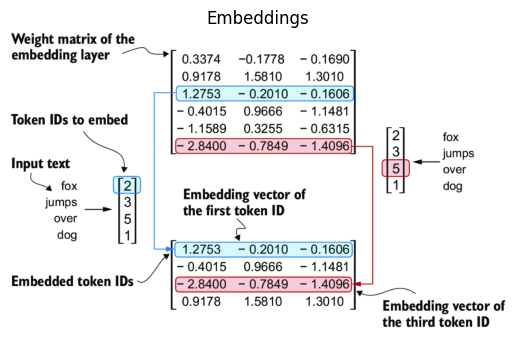

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-16.png",
    title="Embeddings"
)

As camadas de incorporação (_embedding layers_) realizam uma operação de busca (_lookup_), recuperando o vetor de incorporação correspondente ao **ID do token** a partir da matriz de pesos da camada de incorporação.

Por exemplo, o vetor de incorporação do **ID de token** 5 é a sexta linha da matriz de pesos da camada de incorporação (é a sexta, em vez da quinta linha, porque o Python começa a contar do 0). Assumimos que os IDs dos tokens foram produzidos pelo pequeno vocabulário da seção 2.3.

# Codificação de posições (_Posicional Encoding_)

Os _embeddings_ de _tokens_, por si só, **não carregam informação de ordem**, pois o **mecanismo de autoatenção (_self attention_)** dos **LLMs** é **agnóstico à posição dos tokens na sequência**. Para que o modelo consiga compreender a estrutura sequencial da linguagem, é necessário adicionar informações posicionais aos _embeddings_. Isso pode ser feito por meio de:

- **_embeddings_ posicionais absolutos:** que associam um vetor específico a cada posição da sequência; e/ou
- **_embeddings_ posicionais relativos:** que representam a distância entre os tokens.

Ambas as abordagens permitem que o modelo aprenda relações dependentes da ordem, sendo que modelos como o **GPT** utilizam _embeddings_ posicionais **absolutos** treináveis integrados ao processo de aprendizado.

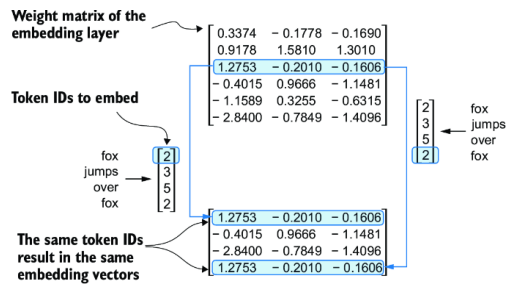

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-17.png",
)

Para alcançar esse objetivo, podemos usar duas categorias principais de _embeddings_ posicionais: **_embeddings_ posicionais relativas** e **_embeddings_ posicionais absolutas**. As **_embeddings_ posicionais absolutas** estão diretamente associadas a posições específicas em uma sequência. Para cada posição na sequência de entrada, um _embeddings_ único é adicionada à _embeddings_ do token para indicar sua localização exata. Por exemplo, o primeiro token terá uma _embeddings_ posicional específica, o segundo token terá outra _embeddings_ distinta e assim por diante.

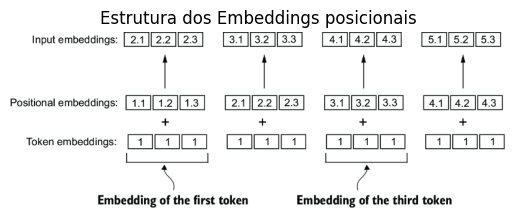

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-18.png",
    title="Estrutura dos Embeddings posicionais"
)

**Contextualização:**

- [Vaswani et al.](https://arxiv.org/abs/1706.03762), 2017 propôs o PE senoidal (uma forma absoluta fixa) e comentou que embeddings posicionais aprendidos funcionavam de forma parecida.

- [Shaw et al.](https://arxiv.org/abs/1803.02155), 2018 introduziram explicitamente relative position representations aplicadas no mecanismo de self-attention — primeira formulação prática que modificava a pontuação de atenção com termos dependentes da distância relativa.

- [Transformer-XL (Dai et al., 2019)](https://arxiv.org/abs/1901.02860) trouxe uma versão de posicionamento relativo projetada para state reuse e extrapolação a janelas maiores (resolver fragmentação de contexto).

- Depois disso vieram variações/aperfeiçoamentos (T5 com bias relativo simples, RoPE/rotary, DeBERTa com atenção disentangulada, ALiBi, KERPLE, etc.) para endereçar generalização de comprimento, eficiência e propriedades matemáticas. Alguns exemplos: T5 usa um relative bias (lookup por distância), RoPE usa multiplicação rotacional para incorporar posição, DeBERTa mistura conteúdo e posição de forma disentangulada.([Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683))


        O livro não aborda toda essa contextualização histórica, mas eu acho interessante coloca-la para entender as coisas. Porque o cara que for estudar o artigo original do transformer não vai ver essa ideia de tipos diferentes de Positional Enconding, e ai, pode ficar meio confuso esse trecho. Então o que o autor esta falando aqui vem de uma evolução específica na área.
    

In [ ]:
# Valores de exemplo
vocab_size = 50257
output_dim = 256

# Instanciando a camada de embedding de tokens
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim) 

- Se amostramos dados do _dataloader_, incorporamos os tokens de cada lote em um vetor de $256$ dimensões.
- Se tivermos um _batch size_ de $8$ unidades com $4$ tokens cada, isso resulta em um tensor de $8 \times 4 \times 256$.

In [ ]:
max_length = 4 # Tamanho da sequência de entrada (janela de contexto)

# Gerando tokens
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False
)   

data_iter = iter(dataloader) # Converte o dataloader em um iterador de batches
inputs, targets = next(data_iter) # pega o primeiro batch desse iterador

In [ ]:
# Obtendo os embeddings dos tokens de entrada
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [ ]:
# Gerando embeddings
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


O **GPT-2** usa _embeddings_ de posição absolute e como estamos seguindo sua estratégia, basta criarmos outra camada de _embeddings_.

In [ ]:
# Instanciando layer de embeddings posicionais
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [ ]:
# Gerando embeddings posicionais
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [ ]:
# Somando os embeddings:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


- Na fase inicial do fluxo de trabalho de processamento de entrada, o texto de entrada é segmentado em tokens separados.
- Após essa segmentação, esses tokens são transformados em IDs de token com base em um vocabulário predefinido.

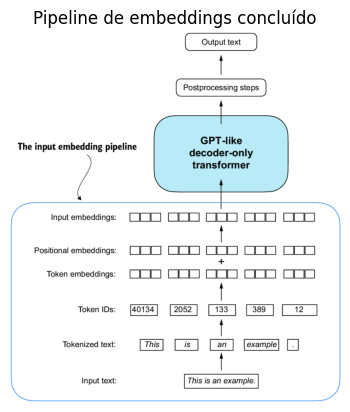

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781633437166/files/Images/2-19.png",
    title="Pipeline de embeddings concluído"
)

**Sumário: Processamento de Dados e Embeddings em LLMs**

- **Vetores Semânticos:** Os LLMs exigem que os dados textuais sejam convertidos em **vetores semânticos**, vetores numéricos conhecidos como _embeddings_, uma vez que não conseguem processar texto bruto. Os _embeddings_ transformam **dados discretos** (como palavras ou imagens) em **espaços vetoriais contínuos**, tornando-os compatíveis com as operações de redes neurais.

- **Tokenização:** Como primeiro passo, o texto bruto é dividido em _tokens_, que podem ser palavras ou caracteres. Em seguida, os _tokens_ são convertidos em **representações de números inteiros**, chamadas de **IDs de token**.

- **Tokens Especiais:** Tokens especiais, como `<|unk|>` (desconhecido) e `<|endoftext|>` (fim de texto), podem ser adicionados para melhorar a compreensão do modelo e lidar com vários contextos, como palavras desconhecidas ou para marcar o limite entre textos não relacionados.

- **BPE (_Byte Pair Encoding_):** O tokenizador **BPE**, usado em modelos como **GPT-2** e **GPT-3**, consegue lidar de forma eficiente com palavras desconhecidas ao decompô-las em unidades de subpalavras ou caracteres individuais.

- **Treinamento:** Utiliza-se uma abordagem de janela deslizante (_sliding window_) nos dados tokenizados para gerar pares de entrada-alvo (_input-target_) para o treinamento do LLM.

- **Camadas de Embedding:** No PyTorch, as camadas de _embedding_ funcionam como uma operação de busca (_lookup_), recuperando os vetores correspondentes aos IDs dos tokens. Os vetores resultantes fornecem representações contínuas dos _tokens_, o que é crucial para treinar modelos de aprendizado profundo.

- **Embeddings Posicionais:** Embora os _embeddings_ de _token_ forneçam representações vetoriais consistentes, eles carecem de uma **noção da posição** do token em uma sequência. Para corrigir isso, existem dois tipos principais de _embeddings_ posicionais: **absolutos** e **relativos**. Os modelos GPT da OpenAI utilizam _embeddings_ posicionais absolutos, que são somados aos vetores de embedding dos tokens e otimizados durante o treinamento do modelo.